In [17]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

import os
import shutil
import zipfile

from tensorflow import feature_column
from keras import layers
from sklearn.model_selection import train_test_split


In [18]:
zip_data = "/content/flower-recognition.zip"
zip_ref = zipfile.ZipFile(zip_data, "r")
zip_ref.extractall('/content')
zip_ref.close()

In [19]:
dataset_dir = os.path.join("flowers")
labels = os.listdir(dataset_dir)

labels

['tulip', 'dandelion', 'sunflower', 'daisy', 'rose']

In [20]:
labels_and_items = {}

for label in labels:
  items = os.listdir(os.path.join(dataset_dir, label))
  labels_and_items[label] = len(items)

labels_and_items

{'daisy': 764, 'dandelion': 1052, 'rose': 784, 'sunflower': 733, 'tulip': 984}

In [21]:
def delete_label(label):
  shutil.rmtree(os.path.join(dataset_dir, label))
  labels.remove(label)
  labels_and_items.pop(label)

In [22]:
delete_label('dandelion')
delete_label('tulip')

In [23]:
labels_and_items

{'daisy': 764, 'rose': 784, 'sunflower': 733}

In [24]:
datagen = ImageDataGenerator(
    rescale=1./255.0,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

In [25]:
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
    
validation_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1827 images belonging to 3 classes.
Found 454 images belonging to 3 classes.


In [26]:

input_shape = (150, 150, 3)

model = tf.keras.models.Sequential([
                                    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                                    layers.MaxPooling2D(2, 2),
                                    layers.Conv2D(64, (3, 3), activation='relu'),
                                    layers.MaxPooling2D(2, 2),                                  
                                    layers.Conv2D(128, (3, 3), activation='relu'),
                                    layers.MaxPooling2D(2, 2),
                                    layers.Flatten(),
                                    layers.Dropout(0.2),
                                    layers.Dense(256, activation='relu'),
                                    layers.Dense(3, activation='softmax')
])

In [27]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [29]:
class MyCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get("accuracy") >= 0.8500 and logs.get("val_accuracy") >= 0.8500:
      print("Accuracy & Val accuracy was over 85%. Stop training...")
      self.model.stop_training = True

callbacks = MyCallback()

In [30]:
hist = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

Epoch 1/50
58/58 [==============================] - 65s 1s/step - loss: 0.8264 - accuracy: 0.6278 - val_loss: 0.6236 - val_accuracy: 0.7533
Epoch 2/50
58/58 [==============================] - 64s 1s/step - loss: 0.5853 - accuracy: 0.7783 - val_loss: 0.5890 - val_accuracy: 0.7775
Epoch 3/50
58/58 [==============================] - 64s 1s/step - loss: 0.5297 - accuracy: 0.7871 - val_loss: 0.5496 - val_accuracy: 0.7974
Epoch 4/50
58/58 [==============================] - 64s 1s/step - loss: 0.4801 - accuracy: 0.8155 - val_loss: 0.5504 - val_accuracy: 0.7841
Epoch 5/50
58/58 [==============================] - 65s 1s/step - loss: 0.4658 - accuracy: 0.8161 - val_loss: 0.5987 - val_accuracy: 0.7819
Epoch 6/50
58/58 [==============================] - 65s 1s/step - loss: 0.4203 - accuracy: 0.8342 - val_loss: 0.5230 - val_accuracy: 0.7952
Epoch 7/50
58/58 [==============================] - 65s 1s/step - loss: 0.3998 - accuracy: 0.8462 - val_loss: 0.4797 - val_accuracy: 0.8128
Epoch 8/50
58/58 [==

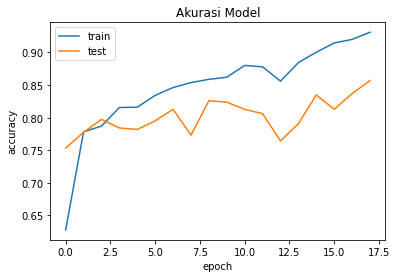

In [31]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Akurasi Model")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

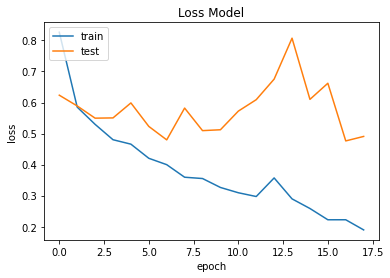

In [32]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss Model")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp7feu6ewi/assets


In [34]:
with tf.io.gfile.GFile("model.tflite", "wb") as f:
  f.write(tflite_model)